# Calculate height from pressure

We need virtual temperature (calculated from cdo - see <a href="../sh_scripts/cdo_mul.sh">cdo_mul.sh</a>)

$$ z_2-z_1 = \frac{287 \ T_v}{g} \cdot log(\frac{p_1}{p_2}) $$

where $p$ is pressure, $g = 9.8$ m/s$^2$, and $T_v$, virtual temperature, is

$$ T_v = (1 + 0.61 \ q_v) \ T $$

where $q_v$ is water vapor (specific humidity) and T is temperature. 



In [1]:
import xarray as xr
import dask
import numpy as np
import analysis_parameters as ap
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

In [2]:
region="TWP"

# SCREAM

In [3]:
chunk_dict={"time":100,"ncol":1000}
Tv = xr.open_dataset(ap.get_file("SCREAM", region=region+"_3D", var="Tv"), chunks=chunk_dict).hus
Tv_avg = (Tv[:,1:,:] + Tv[:,:-1,:].assign_coords(Tv[:,1:,:].coords))/2
Tv

<xarray.DataArray 'hus' (time: 240, lev: 128, ncol: 61250)>
dask.array<open_dataset-fe3b5d47b8894a280626a57674defc3chus, shape=(240, 128, 61250), dtype=float32, chunksize=(100, 128, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2020-01-30 00:00:00 ... 2020-02-28 21:00:00
    lon      (ncol) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    lat      (ncol) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
  * lev      (lev) float64 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
Dimensions without coordinates: ncol
Attributes:
    standard_name:  specific_humidity
    long_name:      Specific humidity
    units:          kg kg-1
    CDI_grid_type:  unstructured
    mdims:          1
    origin:         Q

[########################################] | 100% Completed | 14.4s


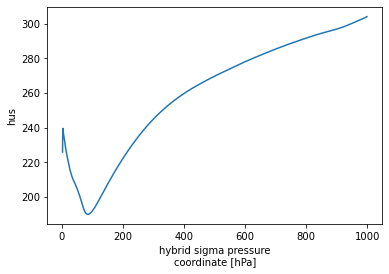

In [4]:
Tv.mean(axis=(0,2)).plot()
plt.show()

In [10]:
p = Tv.lev.values
logp = (np.log((sc_p[1:]/sc_p[:-1]))[np.newaxis,:,np.newaxis])*287/9.8
dz = Tv_avg*logp
z = dz[:,::-1,:].cumsum(axis=(1))[:,::-1,:]
print(z.shape, Tv_avg.shape)

(240, 127, 61250) (240, 127, 61250)


In [ ]:
z.mean(axis=(0,2)).plot(marker=".")
plt.show()

In [12]:
z = xr.Dataset({"zg":xr.DataArray(z, dims=Tv_avg.dims, 
                             attrs={"name":"zg","units":"m"})}, 
           attrs={"long_name":"geopotential height calculated from pressure","name":"height","units":"m"})
z.to_netcdf("/work/bb1153/b380883/TWP/TWP_3D_SCREAM_zg_20200130-20200228.nc")
print("done")

[########################################] | 100% Completed |  2min 31.7s
done


[########################################] | 100% Completed | 19.1s


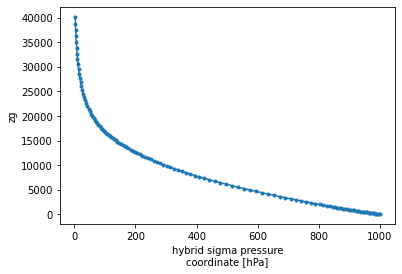

In [17]:
z.zg.mean(axis=(0,2)).plot(marker=".")
plt.show()

# UM 

In [5]:
chunk_dict={"time":100,"latitude":50,"longitude":50}
Tv = xr.open_dataset(ap.get_file("UM", region=region+"_3D", var="Tv"), chunks=chunk_dict).hus
Tv_avg = (Tv[:,1:] + Tv[:,:-1].assign_coords(Tv[:,1:,:].coords))/2

In [6]:
p = xr.open_dataset(ap.get_file("UM", region=region+"_3D", var="phalf"), chunks=chunk_dict).phalf
Tv.shape, sc_p.shape


((240, 55, 214, 142), (240, 55, 214, 142))

[########################################] | 100% Completed |  4.7s


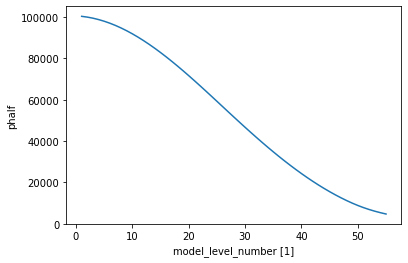

[########################################] | 100% Completed |  4.8s


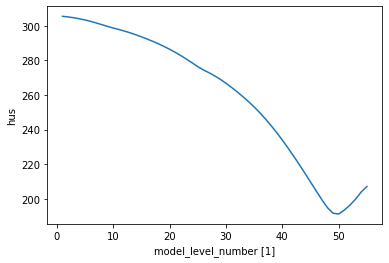

In [15]:
p.mean(axis=(0,2,3)).plot()
plt.show()
Tv.mean(axis=(0,2,3)).plot()
plt.show()

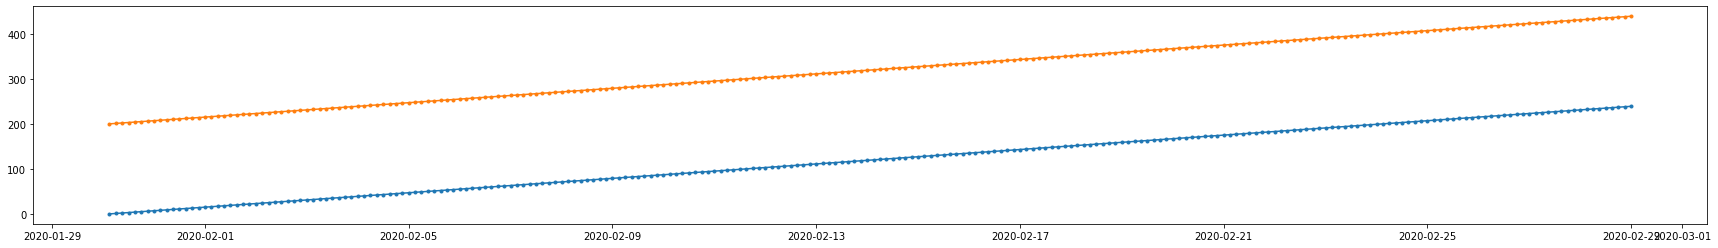

In [5]:
fig = plt.figure(figsize=(30,4))
plt.plot(p.time, np.arange(len(p.time)), ".-")
plt.plot(Tv_avg.time,200+np.arange(len(Tv_avg.time)), ".-")
plt.show()

In [14]:
logp = abs(np.log((p[:,1:].values/p[:,:-1].values)))
dz = 287*Tv_avg*logp/9.8

[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.6s


In [17]:
z = dz.cumsum(axis=(1))
print(z.shape, Tv_avg.shape)

(240, 54, 214, 142) (240, 54, 214, 142)


[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed |  5.5s


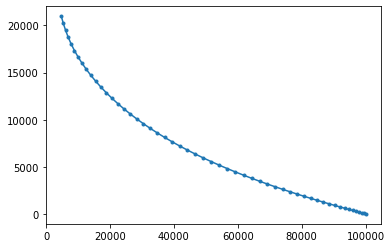

In [20]:
plt.plot(p.mean(axis=(0,2,3))[1:], z.mean(axis=(0,2,3)), marker=".")
plt.show()

[########################################] | 100% Completed |  5.7s


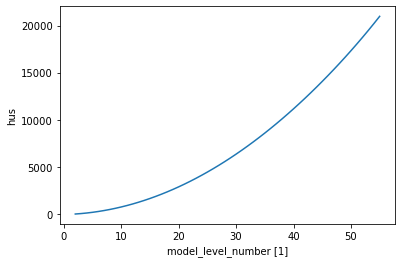

[########################################] | 100% Completed |  5.5s


array(27.243397, dtype=float32)

In [23]:
z.mean(axis=(0,2,3)).plot()
plt.show()
z.min().values

In [24]:
z = xr.Dataset({"zg":xr.DataArray(z, dims=Tv_avg.dims, 
                             attrs={"name":"zg","units":"m"})}, 
           attrs={"long_name":"height from pressure","name":"height","units":"m"})
z.to_netcdf("/work/bb1153/b380883/TWP/TWP_3D_UM_zg_20200130-20200228.nc")
print("done")

[########################################] | 100% Completed | 26.3s
done


# Get pressure from height

\begin{align}{}
z_2-z_1 &= \frac{287 \ T_v}{g} \cdot log(\frac{p_1}{p_2}) \\
\frac{g}{287 \ T_v}dz &= log(\frac{p_1}{p_2}) \\
exp(\frac{g}{287 \ T_v}dz) &= \frac{p_1}{p_2} \\
p_2 &= \frac{p_1}{ exp(\frac{g}{287 \ T_v}dz) }
\end{align}

where $p_1$ is surface pressure given by the 2D output



## SAM

In [ ]:
ta = xr.open_dataset(ap.get_file("SAM","TWP_3D","ta"))
hus = xr.open_dataset(ap.get_file("SAM","TWP_3D","hus"))
z = ta.z





# Get pressure from pthick

```pfull = ps + pthick ```

## GEOS

In [4]:
pthick = xr.open_dataset(ap.get_file("GEOS","TWP_3D","pthick"))
ps = xr.open_dataset(ap.get_file("GEOS","TWP_3D","pthick")).interp({'time':pthick.time, 'Xdim':pthick.Xdim})
print(ps.shape, ps.units, pthick.shape, pthick.units)

In [ ]:
pfull = pthick
pfull[:,0,:] = ps
for i in range(1,len(pfull.levs)):
    pfull[:,i,:] = pfull[:,i-1,:] + pthick[:,i,:]
pfull

In [ ]:
# test 
pfull.mean(axis=(0,2)).plot()
plt.show()

In [ ]:
xr.Dataset({"pfull":pfull},attrs={"standard_name":"pressure","units":"Pa"}